In [1]:
import numpy as np
import os
import stompy.model.delft.dflow_model as dfm
from stompy import utils
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib notebook

In [14]:
# 2016 runs
run_dirs=[#'data_2016long_3d_asbuilt_impaired', # 50 layers, evap
          #'data_2013_3d_asbuilt_impaired-v002'
    
          'data_salt_filling-v05_existing_impaired',
          'data_salt_filling-v04_asbuilt_impaired',
          #'data_2016long_3d_asbuilt_impaired-v001', # 50 layers no evap
          #'data_2016long_3d_asbuilt_impaired-v011', # 60 layers, w/ChangeVelocityAtStructures
          #'data_2016long_3d_asbuilt_impaired-v013', # 60 layers, omits ChangeVelocityAtStructures
    
          #'data_2016long_3d_asbuilt_impaired-v002', # 100 layers
          #'data_2016long_3d_asbuilt_impaired_scen1-v001', # 100 layers
          #'data_2016long_3d_asbuilt_impaired-v003', # default epshu, 50 layers
          #'data_2016long_3d_asbuilt_impaired-v004',# default epshu and 100 layers
          #'data_2016long_3d_asbuilt_impaired-v005',# copy of v001 with new DFM compile
          #'data_short_v000', # should match v001?
          #'data_short_v001', # identical to 0
          #'data_short_v002', 
          #'data_short_v003', 
          #'data_short_v004', # changed bedlevtype, went nan         
          #'data_short_v005', 
          #'data_short_v006',
          #'data_short_v007', # identical to 8
          #'data_short_v008', # very mixed
          #'data_short_v009', # no improvement 
          #'data_short_v011', # no improvement
          #'data_short_v012', 
          #'data_short_v013', 
          #'data_short_v015', # candidate
          #'data_short_v016', # crap
          #'data_short_v017', # crap
          #'data_short_v018', # crap
          #'data_salt_filling-v05_existing_impaired-copy2', # duplicate, should be the same as above
          
          #'data_2016long_3d_existing_impaired',
          #'data_2016long_3d_existing_impaired-v001',
    
         #'data_3d_asbuilt_impaired',
         #'data_3d_existing_impaired',
         #'data_3d_asbuilt_impaired-v001',
         #'data_3d_existing_impaired-v001',
         #'data_3d_asbuilt_impaired-v002', # debug salt?
         #'data_3d_existing_impaired-v002',
         #'data_3d_asbuilt_impaired-v003', # CFLmax=0.35
         #'data_3d_asbuilt_impaired-v004', # dicoww=1e-7
    
         #'data_3d_existing_impaired-v003', # 
         #'data_3d_existing_impaired-v004', # AutoTimestep=5, global time stepping
         #'data_3d_existing_impaired-v005', # CFLmax=0.45 
         #'data_3d_existing_impaired-v006', # limtyp=0 - mixed
         #'data_3d_existing_impaired-v007', # limtyp=9 - bad 
         #'data_3d_existing_impaired-v008', # should be same original 
         #'data_3d_existing_impaired-v009', # should be same original     
         #'data_3d_existing_impaired-v012', # solid run with CFLmax=0.4     
         #'data_3d_asbuilt_impaired-v005', # stalled run with CFLmax=0.4
    
         #'data_2016long_3d_asbuilt_impaired-v015',
         'data_2016long_3d_asbuilt_impaired-v016',
         #'data_2016long_3d_asbuilt_impaired_scen1',
    
         ]

In [3]:

if 0:
    # 2013 runs
    run_dirs=[
        # 'data_2013_3d_asbuilt_impaired-v002', # complete 2013 run. 50 layers. Looks okay.
        #'data_2013_3d_asbuilt_impaired_slr0.61m',  # epshu=0.005. Looks like salt problems
        #'data_2013_3d_asbuilt_impaired_slr0.61m-v001', # default epshu. Looks like salt problems.
    ]

In [15]:
models=[ dfm.DFlowModel.load(run_dir) for run_dir in run_dirs]

<IPython.core.display.Javascript object>


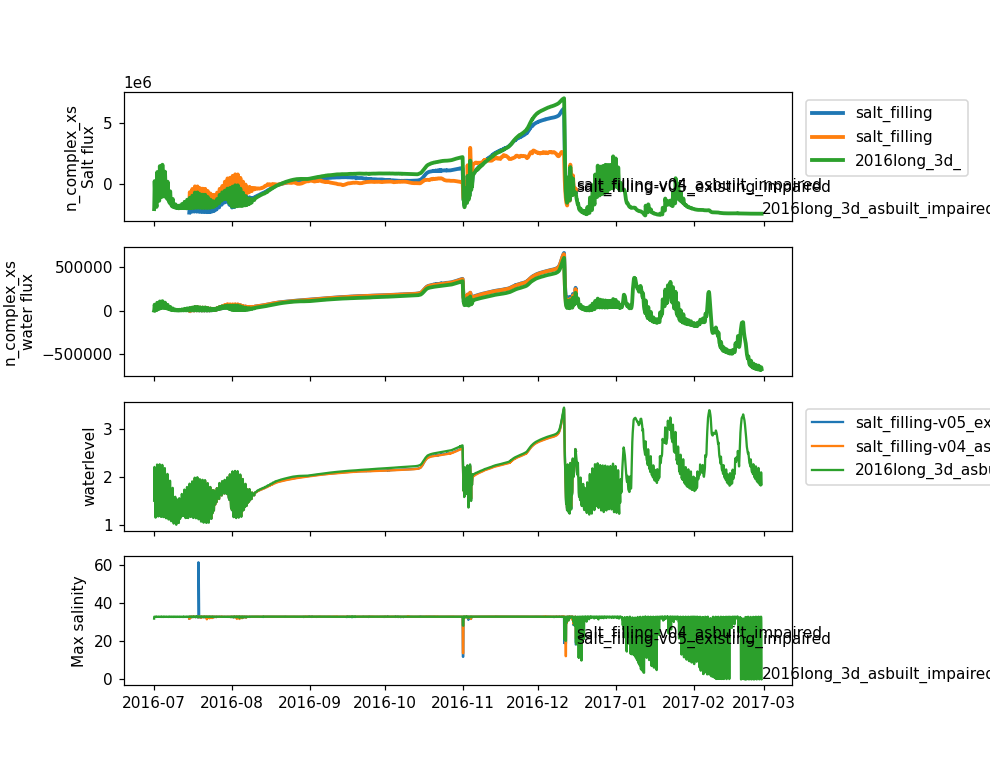

Yuck - duplicate cross_section names
Some lines are degenerate


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Some lines are degenerate


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [16]:
fig,axs=plt.subplots(4,1,sharex=True,figsize=[9,7])

labels=[mod.run_dir for mod in models]
labels=utils.distinct_substrings(labels)

t_ref=np.datetime64("2016-08-20 00:00")

xs='n_complex_xs'
# xs='pesca_mid_xs'

for mod,label in zip(models,labels):
    his_ds=mod.his_dataset(refresh=True)
    
    Qsalt=his_ds['cross_section_cumulative_salt'].sel(cross_section=xs)
    flux_ini=Qsalt.sel(time=t_ref,method='nearest').values
    salt_flux=Qsalt.values - flux_ini
    flux=his_ds['cross_section_cumulative_discharge'].sel(cross_section=xs)
    
    if np.isnan(salt_flux[-1]):
        label="NAN"+label
    axs[0].plot(Qsalt.time, salt_flux,
                label=label[:12],lw=2.5)
    axs[1].plot(flux.time, flux,label=label[:12],lw=2.5)
    
    axs[2].plot(his_ds.time, his_ds['waterlevel'].sel(stations='pc3'),label=label)
    axs[0].text(Qsalt.time.values[-1],
                np.random.random() + salt_flux[-1],label) # hard to see overlapping lines
    
    salt_max=his_ds.salinity.max(dim='stations').max(dim='laydim')
    axs[3].plot(his_ds.time,
                salt_max,
                label=label[:12])
    axs[3].text(his_ds.time.values[-1],
                0.1*np.random.random() + salt_max[-1],label) # hard to see overlapping lines
    
axs[0].set_ylabel(f'{xs}\nSalt flux')
axs[1].set_ylabel(f'{xs}\nwater flux')
axs[2].set_ylabel('waterlevel')
axs[3].set_ylabel('Max salinity')
    
axs[0].legend(loc='upper left',bbox_to_anchor=[1.01,1])
axs[2].legend(loc='upper left',bbox_to_anchor=[1.01,1])
fig.subplots_adjust(right=0.8)
# When the tide is rising, salt flux is going down.
# That means positive flux is downstream.

<IPython.core.display.Javascript object>


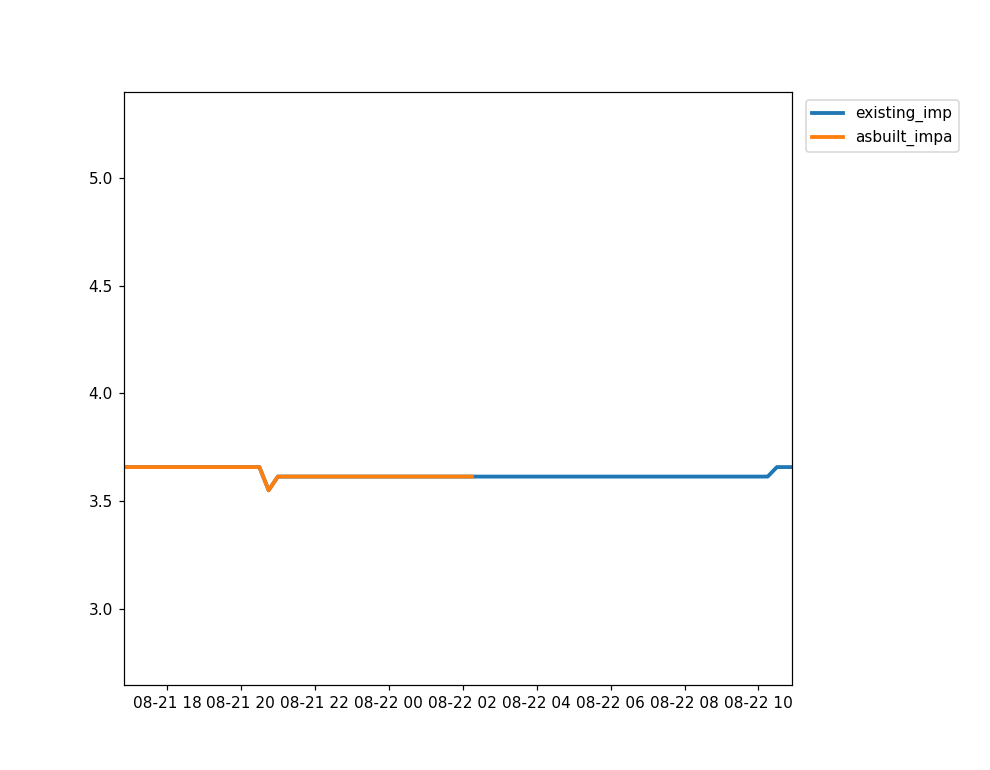

Some lines are degenerate
node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


In [10]:
# compare timesteps
fig,ax=plt.subplots(1,1,sharex=True,figsize=[9,7])

labels=[mod.run_dir for mod in models]
labels=utils.distinct_substrings(labels)

t_ref=np.datetime64("2016-08-20 00:00")

for mod,label in zip(models,labels):
    his_ds=mod.his_dataset(refresh=True)
    
    ax.plot(his_ds.time, his_ds.timestep,
            label=label[:12],lw=2.5)
    
ax.legend(loc='upper left',bbox_to_anchor=[1.01,1])
fig.subplots_adjust(right=0.8)


In [6]:
ds=models[-1].his_dataset()

In [7]:
# how do the
ds

<xarray.Dataset>
Dimensions:                                       (cross_section: 13, gategens: 2, general_structures: 4, laydim: 50, laydimw: 51, nFlowElemContourPts: 4, nFlowElemWithBnd: 3178, nFlowLink: 4834, nFlowLinkPts: 2, nNetLink: 5055, nNetLinkPts: 2, source_sink: 2, source_sink_geom_nNodes: 4, source_sink_pts: 3, station_geom_nNodes: 145, stations: 145, time: 106)
Coordinates:
    station_x_coordinate                          (stations) float64 ...
    station_y_coordinate                          (stations) float64 ...
    station_name                                  (stations) |S256 b'pch_up                                                                                                                                                                                                                                                          ' ... b'seepageB                                                                                                                          

In [13]:
ds['cross_section_cumulative_salt'].sel(cross_section='pesca_mid_xs')

<xarray.DataArray 'cross_section_cumulative_salt' (time: 961)>
array([ 0., nan, nan, ..., nan, nan, nan])
Coordinates:
    cross_section_name  |S256 b'pesca_mid_xs                                                                                                                                                                                                                                                    '
  * time                (time) datetime64[ns] 2016-08-20 ... 2016-08-30
    cross_section       <U15 'pesca_mid_xs'
Attributes:
    long_name:  cumulative flux (based on upwind flow cell) for salt.
    units:      -
    geometry:   cross_section_geom

In [6]:
labels=[mod.run_dir for mod in models]
labels=utils.distinct_substrings(labels)

plt.figure()

for mod,label in zip(models,labels):
    ds=mod.his_dataset()
    l=plt.plot(ds.time,ds.timestep,label=label)
    # And running average:
    plt.plot(ds.time,np.cumsum(ds.timestep)/(1+np.arange(len(ds.time))),
             label='__nolabel__',color=l[0].get_color(),lw=3,alpha=0.6)
                                             
plt.legend()

<IPython.core.display.Javascript object>

NameError: name 'his_dss' is not defined

In [9]:
model=models[0]
mapds=model.map_dataset()

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


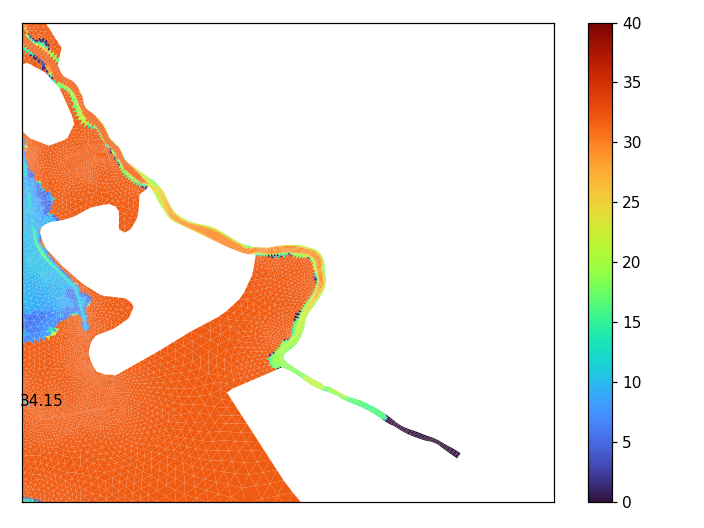

In [13]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)

salt=mapds['mesh2d_sa1'].sel(time=np.datetime64("2016-11-25"),method='nearest').values
salt=np.nanmax(salt,axis=1)
#salt=np.nanmean(salt,axis=1)
ccoll=mapds.grid.plot_cells(values=salt, mask=np.isfinite(salt),cmap='turbo')
#ax.plot(seep_geom[0][1][:,0],seep_geom[0][1][:,1],'r-o')
plt.colorbar(ccoll)
the_spot=mapds.grid.cells_center()[np.argmax(salt)]
plt.text(the_spot[0],the_spot[1],f"{salt.max():.2f}")
ccoll.set_clim([0,40])
fig.tight_layout()

In [40]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)

numlim=mapds['mesh2d_Numlimdt'].isel(time=-1).values
mapds.grid.plot_cells(values=numlim, cmap='turbo')
c=np.argmax(numlim)
cxy=mapds.grid.cells_center()[c]
ax.plot([cxy[0]],[cxy[1]],'ro')

fig.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


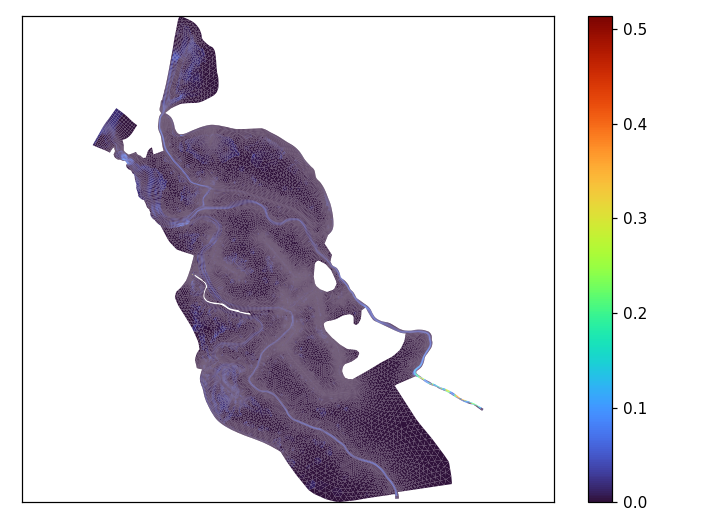

In [29]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)

umag=mapds['mesh2d_ucmaga'].isel(time=-1).values
ccoll=mapds.grid.plot_cells(values=umag, cmap='turbo')
plt.colorbar(ccoll)
fig.tight_layout()

In [31]:
mapds.dims['time']

177

In [24]:
bcs=model.load_bcs()

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=rainfall_rate
Not implemented: reading BC quantity=windxy


In [37]:
#seepage=[bc for bc in bcs if bc['name']=='seepage'][0]
import stompy.model.delft.io as dio
seep_geom=dio.read_pli(os.path.join(model.run_dir,'seepage.pliz'))

In [18]:
mapds

MultiFile Layer on top of <xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 5055, mesh2d_nFaces: 3178, mesh2d_nInterfaces: 51, mesh2d_nLayers: 50, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 1878, time: 56)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.53e+05 ... 5.532e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.124e+06 ... 4.124e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.53e+05 ... 5.532e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.124e+06 ... 4.124e+06
    mesh2d_layer_z               (mesh2d_nLayers) float64 ...
  * time                         (time) datetime64[ns] 2016-07-01 ... 2016-10-19
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_

In [11]:
models[0].run_dir

'data_2016long_3d_asbuilt_impaired-v001'

In [14]:
(np.datetime64("2016-08-20 00:00") - np.datetime64("2016-07-01 00:00"))/np.timedelta64(1,'s')

4320000.0

In [16]:
# is there something weird about the layers when I use 50 layers?
# Can't find anything...

models[0] # 'data_salt_filling-v05_existing_impaired',
models[1] # 'data_2016long_3d_asbuilt_impaired-v001', 

his50=models[1].his_dataset()
his100=models[0].his_dataset()

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist
Yuck - duplicate cross_section names
Some lines are degenerate


In [12]:
# vertical coordinate at center
his50.zcoordinate_c.sel(stations='nck').isel(time=1000)

<xarray.DataArray 'zcoordinate_c' (laydim: 50)>
array([     nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan, 0.095   , 0.165   , 0.235   , 0.305   , 0.375   , 0.445   ,
       0.515   , 0.585   , 0.655   , 0.725   , 0.795   , 0.865   , 0.935   ,
       1.005   , 1.075   , 1.145   , 1.187879,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan])
Coordinates:
    station_x_coordinate  float64 ...
    station_y_coordinate  float64 ...
    station_name          |S256 b'nck                                                                                                                                                                                                                                                             '
    zcoordinat

In [15]:
his50.zcoordinate_w.sel(stations='nck').isel(time=1000)

<xarray.DataArray 'zcoordinate_w' (laydimw: 51)>
array([     nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan, 0.06    , 0.13    , 0.2     , 0.27    , 0.34    , 0.41    ,
       0.48    , 0.55    , 0.62    , 0.69    , 0.76    , 0.83    , 0.9     ,
       0.97    , 1.04    , 1.11    , 1.18    , 1.195759,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan])
Coordinates:
    station_x_coordinate  float64 ...
    station_y_coordinate  float64 ...
    station_name          |S256 b'nck                                                                                                                                                                                                                                                             '
   

In [ ]:
-0.5 + np.arange(50)*0.070

In [34]:
his

<xarray.Dataset>
Dimensions:                                       (cross_section: 10, cross_section_geom_nNodes: 40, gategens: 3, general_structures: 2, laydim: 100, laydimw: 101, nFlowElemContourPts: 4, nFlowElemWithBnd: 2406, nFlowLink: 3977, nFlowLinkPts: 2, nNetLink: 4345, nNetLinkPts: 2, source_sink: 2, source_sink_geom_nNodes: 4, source_sink_pts: 3, station_geom_nNodes: 145, stations: 145, time: 14785)
Coordinates:
    station_x_coordinate                          (stations) float64 ...
    station_y_coordinate                          (stations) float64 ...
    station_name                                  (stations) |S64 b'pch_up' ... b'seepageB'
    zcoordinate_c                                 (time, stations, laydim) float64 ...
    zcoordinate_w                                 (time, stations, laydimw) float64 ...
    zcoordinate_wu                                (time, stations, laydimw) float64 ...
    cross_section_name                            (cross_section) |S64 b'

In [35]:
# for 50 layers, dz is 0.07
# for 100 layers, it's 0.035.
# there is a 0.05 threshold in the code, might be relevant?
# Zbot should be -0.5.

import pandas as pd
for his in [his50,his100]:
    stack=pd.DataFrame()
    t=np.datetime64("2016-09-01")
    ti=np.searchsorted(his.time.values,t)
    stack['z_c']=his.zcoordinate_c.sel(stations='nck').isel(time=ti)
    stack['z_bot']=his.zcoordinate_w.sel(stations='nck').isel(time=ti).values[:-1]
    stack['z_top']=his.zcoordinate_w.sel(stations='nck').isel(time=ti).values[1:]
    stack['dz']=stack['z_top'] - stack['z_bot']
    nlayer=his.dims['laydim']
    zbot=-0.5
    ztop=3.0
    dz_calc=(ztop-zbot)/nlayer
    stack['z_bot_calc']=zbot + np.arange(nlayer)*dz_calc # good to machine precision.
    display(stack)
None

,z_c,z_bot,z_top,dz,z_bot_calc
0,NaN,NaN,NaN,NaN,-0.50
1,NaN,NaN,NaN,NaN,-0.43
2,NaN,NaN,NaN,NaN,-0.36
3,NaN,NaN,NaN,NaN,-0.29
4,NaN,NaN,NaN,NaN,-0.22
5,NaN,NaN,NaN,NaN,-0.15
6,NaN,NaN,NaN,NaN,-0.08
7,NaN,NaN,0.060000,NaN,-0.01
8,0.095000,0.060000,0.130000,0.070000,0.06
9,0.165000,0.130000,0.200000,0.070000,0.13


,z_c,z_bot,z_top,dz,z_bot_calc
0,NaN,NaN,NaN,NaN,-0.500
1,NaN,NaN,NaN,NaN,-0.465
2,NaN,NaN,NaN,NaN,-0.430
3,NaN,NaN,NaN,NaN,-0.395
4,NaN,NaN,NaN,NaN,-0.360
5,NaN,NaN,NaN,NaN,-0.325
6,NaN,NaN,NaN,NaN,-0.290
7,NaN,NaN,NaN,NaN,-0.255
8,NaN,NaN,NaN,NaN,-0.220
9,NaN,NaN,NaN,NaN,-0.185


In [32]:
pd.set_option('display.max_rows', 500)

In [48]:
map_ds100=models[0].map_dataset()
map_ds50=models[1].map_dataset()


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides 

In [53]:
map_ds.dims

Frozen(SortedKeysDict({'mesh2d_nNodes': 1878, 'mesh2d_nEdges': 5055, 'Two': 2, 'mesh2d_nFaces': 3178, 'mesh2d_nMax_face_nodes': 4, 'mesh2d_nLayers': 50, 'mesh2d_nInterfaces': 51, 'time': 80}))

Nlayers: 100
separation -0.001 to 0: 0
separation 0 to 1e-06: 4


<IPython.core.display.Javascript object>


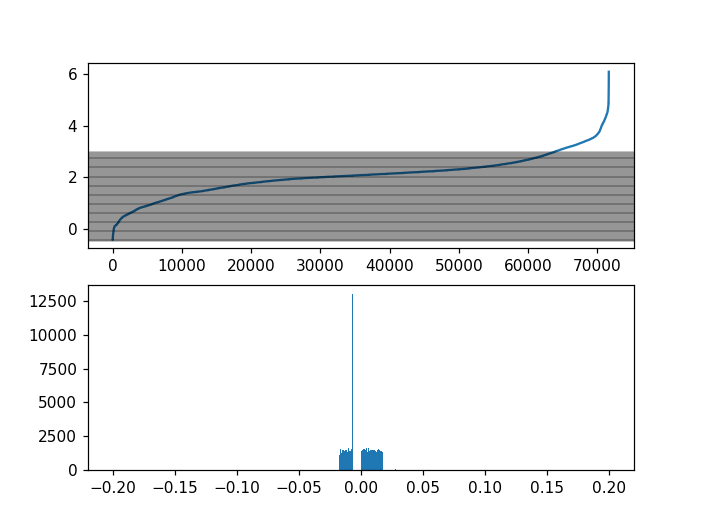

Nlayers: 50
separation -0.001 to 0: 0
separation 0 to 1e-06: 0


<IPython.core.display.Javascript object>


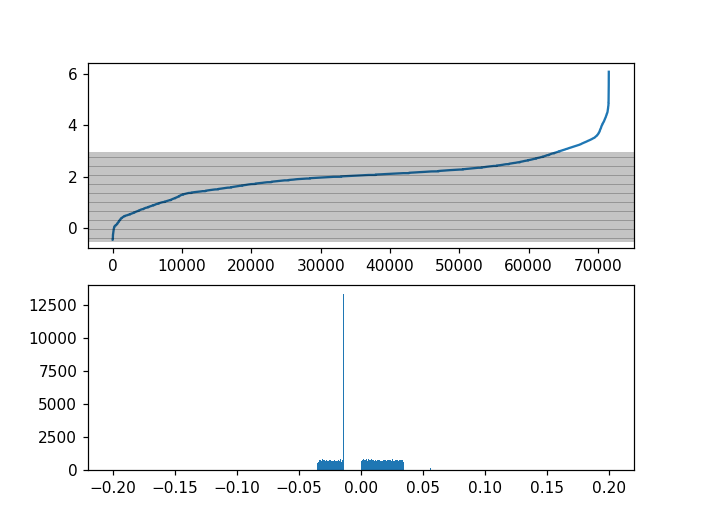

In [65]:
# for the 50 layer case it's possible that we end up cutting it too close
# more often.

for map_ds in [map_ds100,map_ds50]:
    flowelem_bl = map_ds.mesh2d_flowelem_bl.values
    nlayer=map_ds.dims['mesh2d_nLayers']
    dz=3.5/nlayer
    zbots=-0.5 + dz*np.arange(nlayer)
    bls=np.sort(flowelem_bl)
    
    sep=bls - utils.nearest_val(zbots,bls)
        
    print(f"Nlayers: {nlayer}")
    print(f"separation -0.001 to 0: {((sep>=-0.001)&(sep<0.0)).sum()}")
    tol=1e-6
    print(f"separation 0 to {tol}: {((sep>=0.0)&(sep<tol)).sum()}")
    fig,(ax,ax2)=plt.subplots(2,1)
    ax.plot(bls)
    for z in zbots:
        ax.axhline(z,color='k',lw=0.3)
    ax2.hist(sep,bins=np.linspace(-0.2,0.2,501))

In [59]:
sep.min()


-0.03499960233830457